In [1]:
import h5py
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

import os

from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Dense

d:\apps\Anaconda3\envs\keras-cv\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\apps\Anaconda3\envs\keras-cv\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\apps\Anaconda3\envs\keras-cv\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\apps\Anaconda3\envs\keras-cv\lib\site-packages\tensorflow\python\framework\dtypes.

In [2]:
                            # Set up 'ggplot' style
plt.style.use('ggplot')     # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['font.family']     = 'Arial'

In [6]:
# Retrieve data  --------------------------------------------------------------
#
#
#

os.chdir("D:/projects/pattern_ml/Day3")

seed = 7
np.random.seed(seed)

f                   = h5py.File('data/cad5sec.mat')

In [7]:
X = f["data"]       # shape: (1285, 38120)
Y = f["classLabel"] # shape: (1, 38120)

In [8]:
inputs = np.array(X).transpose()  # shape: (38120, 1285)
labels = np.array(Y).transpose()   # shape: (38120, 1)
print(inputs.shape)

(38120, 1285)


In [9]:
nor = inputs[Y[0] == 0.0]
cad = inputs[Y[0] == 1.0]
print(nor.shape)
print(cad.shape)

(32000, 1285)
(6120, 1285)


In [10]:
# stepzation function ---------------------------------------------------------
#
#
# This function creates segmenets of a 1D signal
# It works in batch
#
#
# Dependency:       numpy

def makeSteps(dat, length, dist):
    width           = dat.shape[1]
    numOfSteps      = int(np.floor((width-length)/dist)+1)
    
                                        # Initialize the output
    segments        = np.zeros([dat.shape[0],numOfSteps,length],
                               dtype=dat.dtype)
    
    for l in range(numOfSteps):
        segments[:,l,:]     = dat[:,(l*dist):(l*dist+length)]
        
    return segments

In [11]:
# Splitting data into training and testing set---------------------------------
#
#
#

print('Create dataset (1D signal data)...')
train_nor = nor[0:28800].copy()
test_nor = nor[28800:32000].copy()
train_cad = cad[0:5000].copy()
test_cad = cad[5000:6120].copy()

Create dataset (1D signal data)...


In [15]:
# Create segments from the signals --------------------------------------------
#
#
#

seq_dim = 24
stride = 6

print('Finalizing all the data ....')
train_nor_seqs = makeSteps(train_nor, seq_dim, stride)
test_nor_seqs = makeSteps(test_nor, seq_dim, stride)
train_cad_seqs = makeSteps(train_cad, seq_dim, stride)
test_cad_seqs = makeSteps(test_cad, seq_dim, stride)

train_data = np.vstack([train_nor_seqs,train_cad_seqs])
test_data = np.vstack([test_nor_seqs,test_cad_seqs])

train_labels = np.vstack([np.zeros([train_nor_seqs.shape[0],1]), np.ones([train_cad_seqs.shape[0],1])])
test_labels = np.vstack([np.zeros([test_nor_seqs.shape[0],1]), np.ones([test_cad_seqs.shape[0],1])])

Finalizing all the data ....


In [16]:
train_data.shape  # (n_sample, seq_len, seq_dim)

(33800, 211, 24)

In [18]:
# Creating model --------------------------------------------------------------
#
#
#


print('Creating lstm model...')

modelname   = 'wks3_2_2'

def createModel():    
#    model          = Sequential()
#    model.add(Conv1D(32, 5, activation='relu', input_shape=(trDat.shape[1], length)))
#    model.add(Dropout(0.25))
#    model.add(Conv1D(32, 5, activation='relu'))
#    model.add(MaxPooling1D(2))
#    model.add(Conv1D(48, 5, activation='relu'))
#    model.add(Dropout(0.5))
#    model.add(Conv1D(48, 5, activation='relu'))
#    model.add(MaxPooling1D(2))
#    model.add(Conv1D(64, 5, activation='relu'))
#    model.add(Dropout(0.5))
#    model.add(Conv1D(64, 5, activation='relu'))
#    model.add(MaxPooling1D(2))
#    model.add(LSTM(8,
#                   return_sequences=True, 
#                   dropout=0.5, 
#                   recurrent_dropout=0.5)) 
#    model.add(LSTM(4, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))             
#    model.add(LSTM(2))                                
#    model.add(Dense(1, activation='sigmoid'))
    
    
    # input shape: (seq_len, seq_dim)
    inputs      = Input(shape=(train_data.shape[1], seq_dim))
    
    # shape: (seq_len, seq_dim) ==> (seq_len-(5-1), 32)
    y           = Conv1D(32, 5, activation='relu')(inputs)
    y           = Dropout(0.25)(y)
    
    # shape: (seq_len-(5-1), 32) ==> (seq_len-2*(5-1), 32)
    y           = Conv1D(32, 5, activation='relu')(y)
    
    # shape: (seq_len-2*(5-1), 32) ==> ([seq_len-2*(5-1)]/2, 32)
    y           = MaxPooling1D(2)(y)
    
    # shape: (???, 32) ==> ((???, 48)
    y           = Conv1D(48, 5, activation='relu')(y)
    y           = Dropout(0.5)(y)
    
    # shape: ((???, 48) ==> ((???, 48)
    y           = Conv1D(48, 5, activation='relu')(y)
    y           = MaxPooling1D(2)(y)
    
    # shape: ((???, 48) ==> ((???, 64)
    y           = Conv1D(64, 5, activation='relu')(y)
    y           = Dropout(0.5)(y)
    
    # shape: ((???, 64) ==> ((???, 64)
    y           = Conv1D(64, 5, activation='relu')(y)
    y           = MaxPooling1D(2)(y)
    
    # shape: ((???, 64) ==> ((???, 8)
    y           = LSTM(8, 
                       return_sequences=True, 
                       dropout=0.5, 
                       recurrent_dropout=0.5)(y)
    
    # shape: ((???, 8) ==> ((???, 4)
    y           = LSTM(4, 
                       return_sequences=True, 
                       dropout=0.5, 
                       recurrent_dropout=0.5)(y)
    
    # shape: ((???, 4) ==> (, 2)
    y           = LSTM(2)(y)
    
    # shape: (, 2) ==> (, 1)
    y           = Dense(1, activation='sigmoid')(y)
    
    model       = Model(inputs=inputs,outputs=y)
    
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    return model





                            # Setup the models
model       = createModel() # This is meant for training
modelGo     = createModel() # This is used for final testing

model.summary()

Creating lstm model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 211, 24)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 207, 32)           3872      
_________________________________________________________________
dropout_6 (Dropout)          (None, 207, 32)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 203, 32)           5152      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 101, 32)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 97, 48)            7728      
_________________________________________________________________
dropout_7 (Dropout)          (None, 97, 48)          

In [19]:
                            # Create checkpoint for the training
                            # This checkpoint performs model saving when
                            # an epoch gives highest testing accuracy
filepath        = modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_acc', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

                            # Log the epoch detail into csv
csv_logger      = CSVLogger(modelname +'.csv')
callbacks_list  = [checkpoint,csv_logger]

In [20]:

                            # Fit the model
                            # This is where the training starts
model.fit(train_data, 
          train_labels, 
          validation_data=(test_data, test_labels), 
          epochs=40, 
          batch_size=128,
          shuffle=True,
          callbacks=callbacks_list)

Train on 33800 samples, validate on 4320 samples
Epoch 1/40
33800/33800 [==============================] - 30s 898us/step - loss: 0.5518 - acc: 0.8434 - val_loss: 0.5727 - val_acc: 0.7407
Epoch 2/40
33800/33800 [==============================] - 23s 693us/step - loss: 0.4381 - acc: 0.8520 - val_loss: 0.5899 - val_acc: 0.7407
Epoch 3/40
33800/33800 [==============================] - 23s 695us/step - loss: 0.4211 - acc: 0.8520 - val_loss: 0.6054 - val_acc: 0.7407
Epoch 4/40
33800/33800 [==============================] - 23s 692us/step - loss: 0.4193 - acc: 0.8521 - val_loss: 0.6123 - val_acc: 0.7407
Epoch 5/40
33800/33800 [==============================] - 23s 692us/step - loss: 0.4192 - acc: 0.8520 - val_loss: 0.6132 - val_acc: 0.7407
Epoch 6/40
33800/33800 [==============================] - 23s 693us/step - loss: 0.4192 - acc: 0.8521 - val_loss: 0.6136 - val_acc: 0.7407
Epoch 7/40
33800/33800 [==============================] - 24s 697us/step - loss: 0.4193 - acc: 0.8521 - val_loss: 0.6

In [10]:

                            # Now the training is complete, we get
                            # another object to load the weights
                            # compile it, so that we can do 
                            # final evaluation on it
modelGo.load_weights(filepath)
modelGo.compile(loss='binary_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

In [11]:
                            # Make classification on the test dataset
predicts    = modelGo.predict(test_data)

predicts = [1.0 if prob > 0.5 else 0.0 for prob in predicts]

labelname   = ['Normal','CAD']
                                            # the labels for the classfication report


testScores  = metrics.accuracy_score(test_labels, predicts)
confusion   = metrics.confusion_matrix(test_labels, predicts)


print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(test_labels, predicts, target_names=labelname, digits=4))
print(confusion)

Best accuracy (on testing dataset): 95.62%
              precision    recall  f1-score   support

      Normal     0.9967    0.9441    0.9697      3200
         CAD     0.8611    0.9911    0.9215      1120

    accuracy                         0.9563      4320
   macro avg     0.9289    0.9676    0.9456      4320
weighted avg     0.9616    0.9563    0.9572      4320

[[3021  179]
 [  10 1110]]


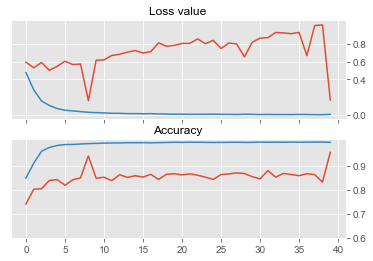

In [12]:
import pandas as pd

records     = pd.read_csv(modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'])
plt.plot(records['loss'])
plt.yticks([0.00,0.40,0.60,0.80])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])



plt.subplot(212)
plt.plot(records['val_acc'])
plt.plot(records['acc'])
plt.yticks([0.6,0.7,0.8,0.9])
plt.title('Accuracy',fontsize=12)
plt.show()

In [13]:
from tensorflow.keras.utils import plot_model

plot_model(model, 
           to_file=modelname+'_CNN_LSTM_model.pdf', 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')